# Emotion recognition using Emo-DB dataset and CNN trained in pytorch

### Database: Emo-DB database (free) 7 emotions
The data can be downloaded from http://emodb.bilderbar.info/index-1024.html

Code of emotions

W->Anger->Wut

L->Boredom->Langeweile

E->Disgust->Ekel

A->Anxiety/Fear->Angst

F->Happiness->Freude

T->Sadness->Trauer

N->Neutral


![image.png](http://iis-projects.ee.ethz.ch/images/thumb/a/a6/Emotions-on-arousal-valence-space.jpg/450px-Emotions-on-arousal-valence-space.jpg)

In [1]:
import requests 
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import itertools
import sys
sys.path.append("../")
import time

# disvoice imports
from phonation.phonation import Phonation
from articulation.articulation import Articulation
from prosody.prosody import Prosody

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# torch imports
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as data

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight

## Download and unzip data


In [3]:
def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)
            
PATH_data="http://emodb.bilderbar.info/download/download.zip"

In [4]:
download_url(PATH_data, "./download.zip")

In [5]:
with zipfile.ZipFile("./download.zip", 'r') as zip_ref:
    zip_ref.extractall("./emo-db/")

## prepare labels from the dataset

we will get labels for two classification problems: 

1. high vs. low arousal emotions
2. positive vs. negative emotions


In [2]:
PATH_AUDIO=os.path.abspath("./emo-db/wav")+"/"
labelsd='WLEAFTN'
labelshl=  [0, 1, 0, 0, 0, 1, 1] # 0 high arousal emotion, 1 low arousal emotions
labelspn=  [0, 0, 0, 0, 1, 0, 1] # 0 negative valence emotion, 1 positive valence emotion

hf=os.listdir(PATH_AUDIO)
hf.sort()

yArousal=np.zeros(len(hf))
yValence=np.zeros(len(hf))
for j in range(len(hf)):
    name_file=hf[j]
    label=hf[j][5]
    poslabel=labelsd.find(label)
    yArousal[j]=labelshl[poslabel]
    yValence[j]=labelspn[poslabel]

## compute features using disvoice: phonation, articulation, prosody, phonological

In [3]:
phonationf=Phonation()
articulationf=Articulation()
prosodyf=Prosody()

## phonation features 

In [4]:
Xphonation=phonationf.extract_features_path(PATH_AUDIO, static=True, plots=False, fmt="torch")
print(Xphonation.size())

Processing 14a07Aa.wav:  69%|██████▉   | 369/535 [00:09<00:04, 41.04it/s]../phonation/phonation.py:142: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data_audio=read(audio)
Processing 16b10Wb.wav: 100%|██████████| 535/535 [00:13<00:00, 39.05it/s]

torch.Size([535, 28])


## articulation features 

In [5]:
Xarticulation=articulationf.extract_features_path(PATH_AUDIO, static=True, plots=False, fmt="torch")
print(Xarticulation.size())

Processing 14a07Aa.wav:  69%|██████▉   | 370/535 [02:05<01:02,  2.64it/s]../articulation/articulation.py:236: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data_audio=read(audio)
Processing 16b10Wb.wav: 100%|██████████| 535/535 [02:56<00:00,  3.09it/s]

torch.Size([535, 488])


## prosody features 

In [6]:
Xprosody=prosodyf.extract_features_path(PATH_AUDIO, static=True, plots=False, fmt="torch")
print(Xprosody.size())

Processing 14a07Aa.wav:  69%|██████▉   | 370/535 [00:51<00:25,  6.52it/s]../prosody/prosody.py:277: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data_audio=read(audio)
Processing 14a07Fd.wav:  70%|██████▉   | 372/535 [00:51<00:24,  6.76it/s]../prosody/prosody.py:277: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data_audio=read(audio)
Processing 14a07Na.wav:  70%|███████   | 375/535 [00:52<00:21,  7.29it/s]../prosody/prosody.py:277: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data_audio=read(audio)
Processing 14a07Wc.wav:  70%|███████   | 377/535 [00:52<00:24,  6.46it/s]../prosody/prosody.py:277: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data_audio=read(audio)
Processing 16b10Wb.wav: 100%|██████████| 535/535 [01:15<00:00,  6.93it/s]

torch.Size([535, 103])


## define architecture of a simple neural network

In [7]:
BATCH_SIZE=16
LR=0.001
class model1(nn.Module):
    def __init__(self, feat_in):
        super().__init__()
        
        self.linear1=nn.Linear(feat_in, 128)
        self.linear2=nn.Linear(128,64)
        self.linear3=nn.Linear(64,2)
        self.dropout=nn.Dropout(p=0.3)
        
    def forward(self, x):
        x=self.dropout(F.leaky_relu(self.linear1(x)))
        x=self.dropout(F.leaky_relu(self.linear2(x)))
        x=F.softmax(self.linear3(x))
        return x

## define dataset loader to train the DNN

In [8]:
class Tdataset(data.Dataset):
    def __init__(self, tensor, labels):
        self.tensor=torch.from_numpy(tensor).float()
        self.labels=torch.from_numpy(labels).long()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        X=self.tensor[idx].float()
        y=self.labels[idx]
        return X, y

## methods to train - evaluate the neural network

In [9]:
def fit(model, train_loader, test_loader, optimizer, criterion, n_epochs=50):

    if torch.cuda.is_available():
        model=model.cuda()  
    valid_loss_min = np.Inf # set initial "min" to infinity
    train_loss_min=np.Inf
    correct_test_max=0
    

    for epoch in range(n_epochs):
        correct_train=0
        correct_test=0
        start=time.time()
        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0
        cdata=0
        model.train() # prep model for training
        #pbar=tqdm(train_loader)
        total_train=0
        for X, y in train_loader:
 
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            if torch.cuda.is_available():
                X=X.cuda()
                y=y.cuda()

            data_out=model(X)
            
            if torch.cuda.is_available():
                data_out=data_out.cuda()
            loss = criterion(data_out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data_out.size(0)
            
            _, predicted = torch.max(data_out.data, 1)
            total_train += y.size(0)
            correct_train += (predicted == y).sum().item()
            
        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        total_val=0
        for X, y in test_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            if torch.cuda.is_available():
                X=X.cuda()
                y=y.cuda()

            data_val_out=model(X)

            if torch.cuda.is_available():
                data_val_out=data_val_out.cuda()

            # calculate the loss
            loss = criterion(data_val_out, y)
            # update running validation loss 
            valid_loss += loss.item()*data_val_out.size(0)
            _, predicted = torch.max(data_val_out.data, 1)
            total_val += y.size(0)
            correct_test+= (predicted == y).sum().item()
            
        train_loss = train_loss/len(train_loader.dataset)
        correct_train=correct_train/total_train
        valid_loss = valid_loss/len(test_loader.dataset)
        correct_test=correct_test/total_val

        print('Epoch: {} \tTraining Loss: {:.6f} \tValid Loss: {:.6f} \tACC train {:.6f} \tACC test {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss,
            correct_train, 
            correct_test,
            ))

        # save model if validation loss has decreased
        if correct_test >= correct_test_max:
            print('Validation Accuracy increased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                correct_test_max,
                correct_test))

            modelr=model
            correct_test_max=correct_test


    return modelr


def predict(model, test_loader):

    model.eval() # prep model for evaluation
    y_pred=[]
    for X, y in test_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        if torch.cuda.is_available():
            X=X.cuda()
        data_val_out=model(X)

        if torch.cuda.is_available():
            data_val_out=data_val_out.cpu()
        y_pred.append(data_val_out.detach().numpy())

    y_pred=np.concatenate(y_pred, axis=0)

    return y_pred

## Emotion classification using a DNN trained in pytorch

In [10]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6,6))
    cm = metrics.confusion_matrix(y_true, y_pred)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, np.round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    
    plt.ylabel('Real class')
    plt.xlabel('Predicted class')
    plt.tight_layout()
    
    
def classify(X, y):
    
    # train test split
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.30, random_state=42)
    
    # z-score standarization
    scaler = preprocessing.StandardScaler().fit(Xtrain) 
    Xtrain=scaler.transform(Xtrain) 
    Xtest=scaler.transform(Xtest)
    

    weights=compute_class_weight('balanced', np.unique(ytrain), ytrain)
    class_weights=torch.from_numpy(weights).float()
    train=Tdataset(Xtrain, ytrain)
    test=Tdataset(Xtest, ytest)

    train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, drop_last=True, num_workers=0)
    test_loader = torch.utils.data.DataLoader(test, batch_size=1, drop_last=True, num_workers=0)

    model=model1(X.size()[1])
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr = LR)
        
    model=fit(model, train_loader, test_loader, optimizer, criterion)
    
    ypred=predict(model, test_loader)
    score_test=ypred[:,1]
    ypred=np.argmax(ypred, 1)

    acc=metrics.accuracy_score(ytest, ypred)
    cm=metrics.confusion_matrix(ytest, ypred)
    AUC=metrics.roc_auc_score(ytest, score_test)
    dfclass=metrics.classification_report(ytest, ypred,digits=4)

    # display the results
    
    plot_confusion_matrix(ytest, ypred, classes=["class 0", "class 1"], normalize=True)
    
    plt.figure(figsize=(5,5))
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
    fprs, tprs, thresholds = metrics.roc_curve(ytest, score_test)
    plt.plot(fprs, tprs, color='k',
         label=r'Avg. ROC (AUC = %0.3f)' % (AUC),
         lw=2, alpha=.8)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    
    plt.show()
    print("Accuracy: ", acc)
    print(dfclass)


## classify high vs. low arousal with the different feature sets

/home/camilo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Epoch: 0 	Training Loss: 0.608544 	Valid Loss: 0.557118 	ACC train 0.652174 	ACC test 0.801242
Validation Accuracy increased (0.000000 --> 0.801242).  Saving model ...
Epoch: 1 	Training Loss: 0.479208 	Valid Loss: 0.469077 	ACC train 0.839674 	ACC test 0.844720
Validation Accuracy increased (0.801242 --> 0.844720).  Saving model ...
Epoch: 2 	Training Loss: 0.425783 	Valid Loss: 0.447978 	ACC train 0.877717 	ACC test 0.857143
Validation Accuracy increased (0.844720 --> 0.857143).  Saving model ...
Epoch: 3 	Training Loss: 0.411075 	Valid Loss: 0.440468 	ACC train 0.885870 	ACC test 0.869565
Validation Accuracy increased (0.857143 --> 0.869565).  Saving model ...
Epoch: 4 	Training Loss: 0.398951 	Valid Loss: 0.436368 	ACC train 0.915761 	ACC test 0.888199
Validation Accuracy increased (0.869565 --> 0.888199).  Saving model ...
Epoch: 5 	Training Loss: 0.390725 	Valid Loss: 0.433551 	ACC train 0.910326 	ACC test 0.869565
Epoch: 6 	Training Loss: 0.379741 	Valid Loss: 0.434383 	ACC trai

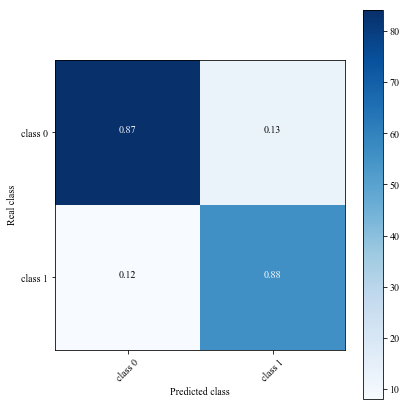

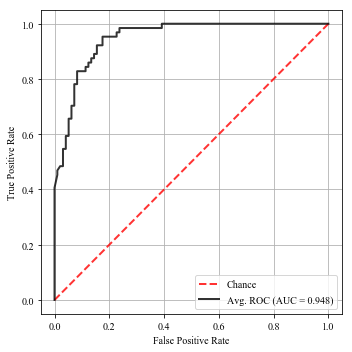

Accuracy:  0.8695652173913043
              precision    recall  f1-score   support

         0.0     0.9130    0.8660    0.8889        97
         1.0     0.8116    0.8750    0.8421        64

    accuracy                         0.8696       161
   macro avg     0.8623    0.8705    0.8655       161
weighted avg     0.8727    0.8696    0.8703       161



In [11]:
classify(Xphonation, yArousal)

/home/camilo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Epoch: 0 	Training Loss: 0.561660 	Valid Loss: 0.446655 	ACC train 0.809783 	ACC test 0.919255
Validation Accuracy increased (0.000000 --> 0.919255).  Saving model ...
Epoch: 1 	Training Loss: 0.384198 	Valid Loss: 0.378334 	ACC train 0.937500 	ACC test 0.950311
Validation Accuracy increased (0.919255 --> 0.950311).  Saving model ...
Epoch: 2 	Training Loss: 0.342262 	Valid Loss: 0.366112 	ACC train 0.975543 	ACC test 0.956522
Validation Accuracy increased (0.950311 --> 0.956522).  Saving model ...
Epoch: 3 	Training Loss: 0.328196 	Valid Loss: 0.357785 	ACC train 0.980978 	ACC test 0.950311
Epoch: 4 	Training Loss: 0.322309 	Valid Loss: 0.355779 	ACC train 0.986413 	ACC test 0.950311
Epoch: 5 	Training Loss: 0.320085 	Valid Loss: 0.356567 	ACC train 0.989130 	ACC test 0.956522
Validation Accuracy increased (0.956522 --> 0.956522).  Saving model ...
Epoch: 6 	Training Loss: 0.315674 	Valid Loss: 0.355210 	ACC train 0.994565 	ACC test 0.950311
Epoch: 7 	Training Loss: 0.314862 	Valid Lo

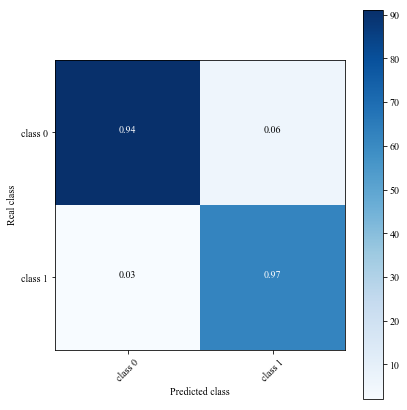

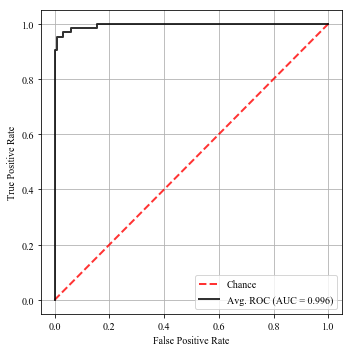

Accuracy:  0.9503105590062112
              precision    recall  f1-score   support

         0.0     0.9785    0.9381    0.9579        97
         1.0     0.9118    0.9688    0.9394        64

    accuracy                         0.9503       161
   macro avg     0.9451    0.9534    0.9486       161
weighted avg     0.9520    0.9503    0.9505       161



In [12]:
classify(Xarticulation, yArousal)

/home/camilo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Epoch: 0 	Training Loss: 0.616675 	Valid Loss: 0.550142 	ACC train 0.755435 	ACC test 0.826087
Validation Accuracy increased (0.000000 --> 0.826087).  Saving model ...
Epoch: 1 	Training Loss: 0.477215 	Valid Loss: 0.472122 	ACC train 0.828804 	ACC test 0.838509
Validation Accuracy increased (0.826087 --> 0.838509).  Saving model ...
Epoch: 2 	Training Loss: 0.416971 	Valid Loss: 0.448236 	ACC train 0.896739 	ACC test 0.869565
Validation Accuracy increased (0.838509 --> 0.869565).  Saving model ...
Epoch: 3 	Training Loss: 0.383487 	Valid Loss: 0.434629 	ACC train 0.940217 	ACC test 0.881988
Validation Accuracy increased (0.869565 --> 0.881988).  Saving model ...
Epoch: 4 	Training Loss: 0.364876 	Valid Loss: 0.431065 	ACC train 0.945652 	ACC test 0.875776
Epoch: 5 	Training Loss: 0.355004 	Valid Loss: 0.427323 	ACC train 0.959239 	ACC test 0.888199
Validation Accuracy increased (0.881988 --> 0.888199).  Saving model ...
Epoch: 6 	Training Loss: 0.341942 	Valid Loss: 0.425811 	ACC trai

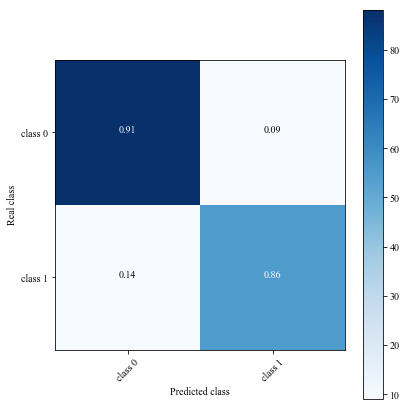

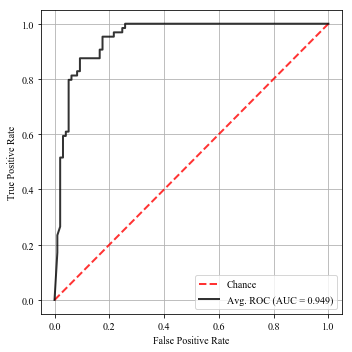

Accuracy:  0.8881987577639752
              precision    recall  f1-score   support

         0.0     0.9072    0.9072    0.9072        97
         1.0     0.8594    0.8594    0.8594        64

    accuracy                         0.8882       161
   macro avg     0.8833    0.8833    0.8833       161
weighted avg     0.8882    0.8882    0.8882       161



In [13]:
classify(Xprosody, yArousal)

## classify positive vs. negative valence with the different feature sets

/home/camilo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Epoch: 0 	Training Loss: 0.681168 	Valid Loss: 0.668663 	ACC train 0.717391 	ACC test 0.677019
Validation Accuracy increased (0.000000 --> 0.677019).  Saving model ...
Epoch: 1 	Training Loss: 0.672975 	Valid Loss: 0.672795 	ACC train 0.706522 	ACC test 0.658385
Epoch: 2 	Training Loss: 0.666014 	Valid Loss: 0.670217 	ACC train 0.703804 	ACC test 0.639752
Epoch: 3 	Training Loss: 0.655968 	Valid Loss: 0.668090 	ACC train 0.709239 	ACC test 0.658385
Epoch: 4 	Training Loss: 0.650593 	Valid Loss: 0.665711 	ACC train 0.720109 	ACC test 0.689441
Validation Accuracy increased (0.677019 --> 0.689441).  Saving model ...
Epoch: 5 	Training Loss: 0.633793 	Valid Loss: 0.660105 	ACC train 0.717391 	ACC test 0.683230
Epoch: 6 	Training Loss: 0.629537 	Valid Loss: 0.661399 	ACC train 0.701087 	ACC test 0.670807
Epoch: 7 	Training Loss: 0.630014 	Valid Loss: 0.650817 	ACC train 0.687500 	ACC test 0.664596
Epoch: 8 	Training Loss: 0.594066 	Valid Loss: 0.649553 	ACC train 0.739130 	ACC test 0.683230

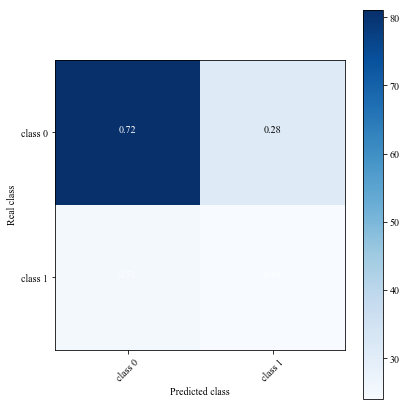

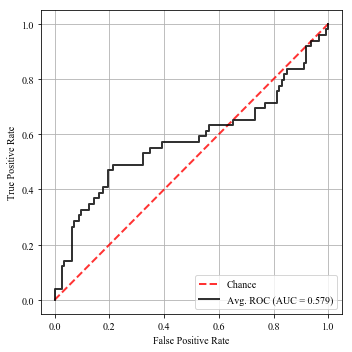

Accuracy:  0.6521739130434783
              precision    recall  f1-score   support

         0.0     0.7642    0.7232    0.7431       112
         1.0     0.4364    0.4898    0.4615        49

    accuracy                         0.6522       161
   macro avg     0.6003    0.6065    0.6023       161
weighted avg     0.6644    0.6522    0.6574       161



In [14]:
classify(Xphonation, yValence)

/home/camilo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Epoch: 0 	Training Loss: 0.659876 	Valid Loss: 0.637997 	ACC train 0.578804 	ACC test 0.689441
Validation Accuracy increased (0.000000 --> 0.689441).  Saving model ...
Epoch: 1 	Training Loss: 0.555421 	Valid Loss: 0.576585 	ACC train 0.793478 	ACC test 0.714286
Validation Accuracy increased (0.689441 --> 0.714286).  Saving model ...
Epoch: 2 	Training Loss: 0.453222 	Valid Loss: 0.550290 	ACC train 0.913043 	ACC test 0.776398
Validation Accuracy increased (0.714286 --> 0.776398).  Saving model ...
Epoch: 3 	Training Loss: 0.385608 	Valid Loss: 0.543956 	ACC train 0.953804 	ACC test 0.770186
Epoch: 4 	Training Loss: 0.353239 	Valid Loss: 0.534874 	ACC train 0.970109 	ACC test 0.763975
Epoch: 5 	Training Loss: 0.326766 	Valid Loss: 0.536180 	ACC train 0.997283 	ACC test 0.782609
Validation Accuracy increased (0.776398 --> 0.782609).  Saving model ...
Epoch: 6 	Training Loss: 0.315822 	Valid Loss: 0.541353 	ACC train 0.997283 	ACC test 0.763975
Epoch: 7 	Training Loss: 0.316156 	Valid Lo

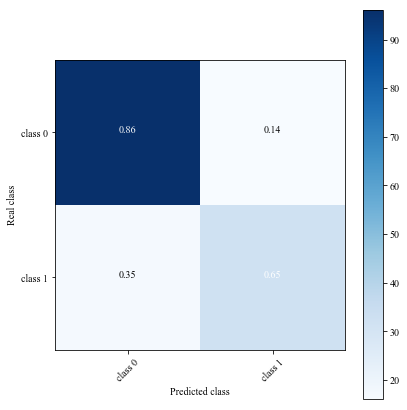

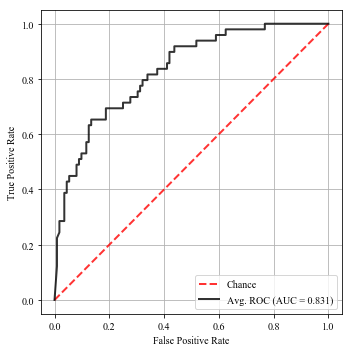

Accuracy:  0.7950310559006211
              precision    recall  f1-score   support

         0.0     0.8496    0.8571    0.8533       112
         1.0     0.6667    0.6531    0.6598        49

    accuracy                         0.7950       161
   macro avg     0.7581    0.7551    0.7566       161
weighted avg     0.7939    0.7950    0.7944       161



In [16]:
classify(Xarticulation, yValence)

/home/camilo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Epoch: 0 	Training Loss: 0.672192 	Valid Loss: 0.649377 	ACC train 0.486413 	ACC test 0.664596
Validation Accuracy increased (0.000000 --> 0.664596).  Saving model ...
Epoch: 1 	Training Loss: 0.631459 	Valid Loss: 0.616110 	ACC train 0.684783 	ACC test 0.683230
Validation Accuracy increased (0.664596 --> 0.683230).  Saving model ...
Epoch: 2 	Training Loss: 0.597454 	Valid Loss: 0.604785 	ACC train 0.706522 	ACC test 0.695652
Validation Accuracy increased (0.683230 --> 0.695652).  Saving model ...
Epoch: 3 	Training Loss: 0.562255 	Valid Loss: 0.586377 	ACC train 0.730978 	ACC test 0.701863
Validation Accuracy increased (0.695652 --> 0.701863).  Saving model ...
Epoch: 4 	Training Loss: 0.527864 	Valid Loss: 0.578370 	ACC train 0.798913 	ACC test 0.683230
Epoch: 5 	Training Loss: 0.488274 	Valid Loss: 0.581185 	ACC train 0.834239 	ACC test 0.683230
Epoch: 6 	Training Loss: 0.449807 	Valid Loss: 0.575696 	ACC train 0.875000 	ACC test 0.701863
Validation Accuracy increased (0.701863 -->

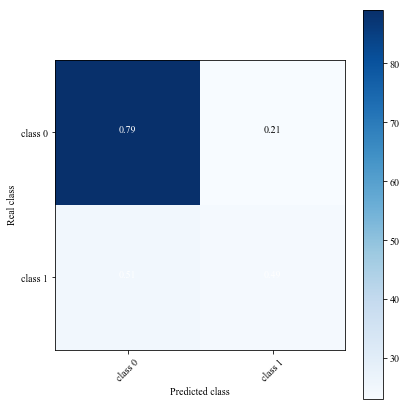

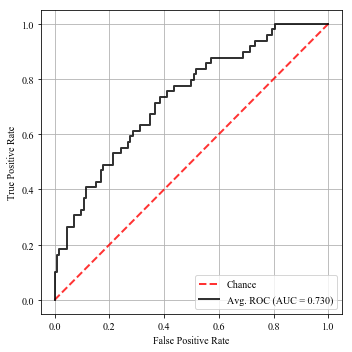

Accuracy:  0.7018633540372671
              precision    recall  f1-score   support

         0.0     0.7807    0.7946    0.7876       112
         1.0     0.5106    0.4898    0.5000        49

    accuracy                         0.7019       161
   macro avg     0.6457    0.6422    0.6438       161
weighted avg     0.6985    0.7019    0.7001       161



In [17]:
classify(Xprosody, yValence)